In [10]:
import cassiopeia as cas
import json

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import pandas as pd
import os
import sys
cwd = os.getcwd()
curr_head_dir = "/".join(cwd.split("/")[:-1])

sys.path.append(curr_head_dir + '/src/')
# import cell_fate_mapping_utils as utils
import cell_fate_mapping_utils

In [11]:
def state_set_to_int(state_set, states):
    tot = 0
    for i in range(len(states)):
        if states[i] in state_set:
            tot += 2**i
    return tot

def get_progens_from_tree_input(file):
    tree = cas.data.CassiopeiaTree(tree = file)
    for l in tree.leaves:
        tree.set_attribute(l, "state_labels", [l])
    for n in tree.internal_nodes:
        tree.set_attribute(n, "state_labels", [])
    cell_fate_mapping_utils.impute_states_from_children(tree)

    return [tree.get_attribute(n, "state_labels") for n in tree.internal_nodes]

def get_progens_from_fate_map_graph(file):
    graph_dicts = []
    with open(file, 'r') as graph_file:
        for line in graph_file:
            graph_dicts.append(json.loads(line))

    progens = []
    states = max(graph_dicts[2].values(), key = len)
    for key, val in graph_dicts[2].items():
        if type(val) == list:
            progens.append(sorted(val))
            
    return progens, sorted(states)

def get_progens_from_ilp_output(file):
    progens = []
    with open(file, 'r') as inp:
        for line in inp:
            progens.append([x.lstrip("'").rstrip("'") for x in line.rstrip('}\n').lstrip('{').split(', ')])

    return progens

def jaccard_dist(s1, s2, states):
    s1 = set([state_set_to_int(s, states) for s in s1])
    s2 = set([state_set_to_int(s, states) for s in s2])

    return 1 - len(s1.intersection(s2))/len(s1.union(s2))

def sum_of_min_jaccard_dist(s1, s2):
    tot_dist = 0
    for s in s1:
        s = set(s)
        min_dist = 1
        for s_ in s2:
            s_ = set(s_)
            dist = 1 - len(s.intersection(s_))/len(s.union(s_))
            if dist < min_dist:
                min_dist = dist
        tot_dist += min_dist
    return tot_dist

def sum_of_min_symmetric_difference(s1, s2):
    tot_dist = 0
    for s in s1:
        s = set(s)
        min_dist = np.inf
        for s_ in s2:
            s_ = set(s_)
            dist = len(s.union(s_) - s.intersection(s_))
            if dist < min_dist:
                min_dist = dist
        tot_dist += min_dist
    return tot_dist

def classification_scores(ground, recon, states):
    ground = set([state_set_to_int(s, states) for s in ground])
    recon = set([state_set_to_int(s, states) for s in recon])

    true_positives = len(recon.intersection(ground))

    possible_progens = 2**len(states) - len(states) - 1

    precision = true_positives/len(recon)
    recall = true_positives/len(ground)
    false_positive_rate = len(recon - ground)/(possible_progens - len(ground))

    return precision, recall, false_positive_rate

In [44]:
algorithm_output_stubs = {
    "ilp": "_progenitors.txt",
    "evoc": "_EvoCGraph.nwk",
    "qfm": "_IceFaseGraph.nwk"
}

algorithm_output_dir = {
    "ilp": "ilp",
    "evoc": "evo_time",
    # "qfm": "ice_fase_gt_input",
    "qfm": "qfm"
}

cell_state_nums = [4, 6]
ks = [2, 4, 6]
cells_sampled_nums = [50, 100, 150]
sub_sampling_rates = [20]

num_fatemap_reps = 5
num_tree_reps = 5

In [45]:
rows = []

for num_cell_states in cell_state_nums:
    for k in ks:
        if k > num_cell_states - 2:
            continue
            
        for fatemap_ind in range(num_fatemap_reps):
        
            gt_loc = f"{curr_head_dir}/data/tree_simulation/fate_maps/{num_cell_states}_{k}_{fatemap_ind}_fateMapGraph.txt"
            gt_progens, states = get_progens_from_fate_map_graph(gt_loc)

            for num_cells_sampled in cells_sampled_nums:
                for rate in sub_sampling_rates:
                    for tree_ind in range(num_tree_reps):
                        for alg, alg_stub in algorithm_output_stubs.items():

                            alg_dir = algorithm_output_dir[alg]
                            file_loc = f"{curr_head_dir}/data/tree_simulation/{alg_dir}/{num_cell_states}_{k}_{fatemap_ind}_{num_cells_sampled}_{rate}_{tree_ind}{alg_stub}"

                            if "progenitors" in alg_stub:
                                res_progens = get_progens_from_ilp_output(file_loc)
                            else:
                                res_progens = get_progens_from_tree_input(file_loc)

                            dist = jaccard_dist(gt_progens, res_progens, states)
                            sum_min_jacc = sum_of_min_jaccard_dist(gt_progens, res_progens)
                            sum_min_sd = sum_of_min_symmetric_difference(gt_progens, res_progens)
                            precision, recall, fpr = classification_scores(gt_progens, res_progens, states)

                            rows.append([
                                num_cell_states,
                                k,
                                fatemap_ind,
                                num_cells_sampled,
                                rate,
                                tree_ind,
                                alg,
                                dist,
                                sum_min_jacc,
                                sum_min_sd,
                                precision,
                                recall,
                                fpr
                            ])


results = pd.DataFrame(rows, columns = ["nstates",
                                        "k",
                                        "fate_ind",
                                        "ncells",
                                        "rate",
                                        "tree_ind",
                                        "method", 
                                        "jaccard_dist",
                                       "sum_of_min_jaccard",
                                       "sum_of_min_symmetric_diff",
                                       "precision",
                                       "recall",
                                       "fpr"])
# results.to_csv(f"{curr_head_dir}/data/simulation/results/rf_scores.txt", sep='\t')

In [46]:
df_results = results

In [48]:
sort_dict = {'ilp':0, 'evoc':2,'qfm':1}
df_results = df_results.iloc[df_results['method'].map(sort_dict).sort_values().index]

In [49]:
method_color_dictionary = {'observed': 'gray',
                           'ilp': sns.color_palette()[0],
                           'evoc': sns.color_palette()[1],
                           'qfm': sns.color_palette()[2]}

In [50]:
df_results['norm_sum'] = df_results['sum_of_min_jaccard'] / df_results['nstates'] / df_results['k']

/tmp/ipykernel_2971353/3106980505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['norm_sum'] = df_results['sum_of_min_jaccard'] / df_results['nstates'] / df_results['k']


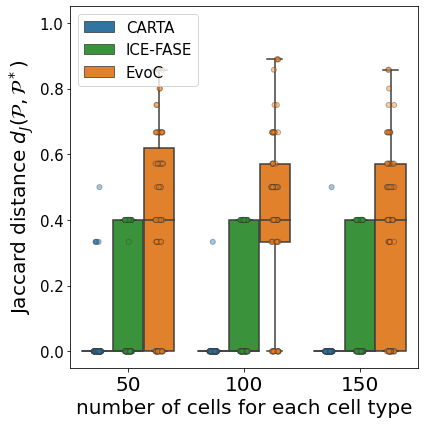

In [51]:
df_plot = df_results[(df_results['nstates'] > 0)]

fig, ax = plt.subplots(1,1)
ax = sns.boxplot(x='ncells', y='jaccard_dist', hue='method', palette= method_color_dictionary,
                 data=df_plot, showfliers = False)
ax = sns.stripplot(data=df_plot, x="ncells", y="jaccard_dist", hue="method",
              alpha=.4, dodge=True, linewidth=1, jitter=.1, palette=method_color_dictionary)
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[0:3], [r'CARTA', r'ICE-FASE', r'EvoC'],loc = 'upper left', fontsize=15)

ax.set_ylim((-0.05, 1.05))
plt.gcf().set_size_inches((6,6))
plt.gca().set_xlabel(r'number of cells for each cell type', fontsize=20)
plt.gca().set_ylabel(r'Jaccard distance $d_J(\mathcal{P}, \mathcal{P}^*)$', fontsize=20);

plt.gca().set_xticklabels(['50', '100', '150'], fontsize=20)
plt.yticks(fontsize=15)

plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/tree_jaccard_dist_ncells.pdf', bbox_inches='tight')

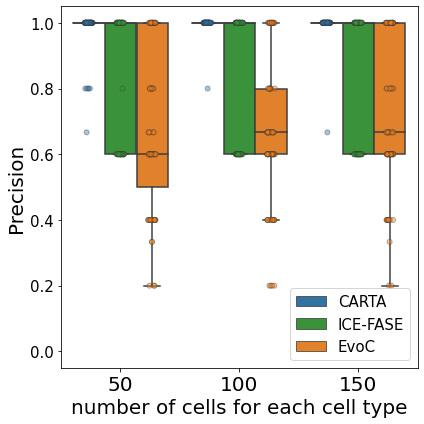

In [52]:
df_plot = df_results[(df_results['nstates'] > 0)]

fig, ax = plt.subplots(1,1)
ax = sns.boxplot(x='ncells', y='precision', hue='method', palette= method_color_dictionary,
                 data=df_plot, showfliers = False)
ax = sns.stripplot(data=df_plot, x="ncells", y="precision", hue="method",
              alpha=.4, dodge=True, linewidth=1, jitter=.1, palette=method_color_dictionary)
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[0:3], [r'CARTA', r'ICE-FASE', r'EvoC'],loc = 'best', fontsize=15)

ax.set_ylim((-0.05, 1.05))
plt.gcf().set_size_inches((6,6))
plt.gca().set_xlabel(r'number of cells for each cell type', fontsize=20)
plt.gca().set_ylabel(r'Precision', fontsize=20);

plt.gca().set_xticklabels(['50', '100', '150'], fontsize=20)
plt.yticks(fontsize=15)

plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/tree_precision_ncells.pdf', bbox_inches='tight')

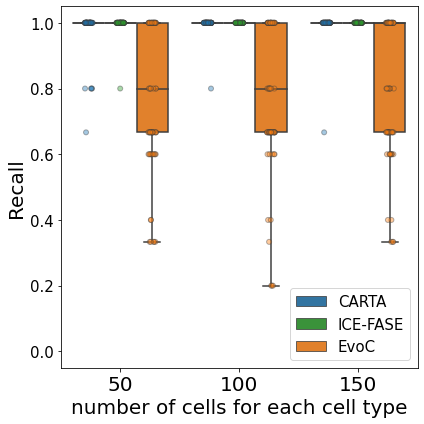

In [53]:
df_plot = df_results[(df_results['nstates'] > 0)]

fig, ax = plt.subplots(1,1)
ax = sns.boxplot(x='ncells', y='recall', hue='method', palette= method_color_dictionary,
                 data=df_plot, showfliers = False)
ax = sns.stripplot(data=df_plot, x="ncells", y="recall", hue="method",
              alpha=.4, dodge=True, linewidth=1, jitter=.1, palette=method_color_dictionary)
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[0:3], [r'CARTA', r'ICE-FASE', r'EvoC'],loc = 'best', fontsize=15)

ax.set_ylim((-0.05, 1.05))
plt.gcf().set_size_inches((6,6))
plt.gca().set_xlabel(r'number of cells for each cell type', fontsize=20)
plt.gca().set_ylabel(r'Recall', fontsize=20);

plt.gca().set_xticklabels(['50', '100', '150'], fontsize=20)
plt.yticks(fontsize=15)

plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/tree_recall_ncells.pdf', bbox_inches='tight')

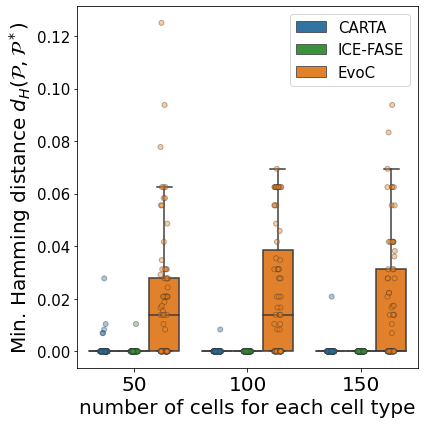

In [54]:
# df_plot = df_results[(df_results['nstates'] > 0)]

fig, ax = plt.subplots(1,1)
ax = sns.boxplot(x='ncells', y='norm_sum', hue='method', palette= method_color_dictionary,
                 data=df_plot, showfliers = False)
ax = sns.stripplot(data=df_plot, x="ncells", y="norm_sum", hue="method",
              alpha=.4, dodge=True, linewidth=1, jitter=.1, palette=method_color_dictionary)
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[0:3], [r'CARTA', r'ICE-FASE', r'EvoC'],loc = 'best', fontsize=15)

# ax.set_ylim((-0.05, 1.05))
plt.gcf().set_size_inches((6,6))
plt.gca().set_xlabel(r'number of cells for each cell type', fontsize=20)
plt.gca().set_ylabel(r'Min. Hamming distance $d_H(\mathcal{P}, \mathcal{P}^*)$', fontsize=20);

plt.gca().set_xticklabels(['50', '100', '150'], fontsize=20)
plt.yticks(fontsize=15)

plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/tree_hamming_ncells.pdf', bbox_inches='tight')